## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Import all dependencies

In [1]:
import cv2
import numpy as np
import glob 
import matplotlib.pyplot as plt
%matplotlib qt

## computing the camera calibration using chessboard images

In [2]:
def get_cal_matrix():
    '''Calculate the transformation matrix for correcting image dis'''
    nx = 9 
    ny = 6
    images = glob.glob('camera_cal/calibration*.jpg')  #fetch path of all images
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for img_path in images:
        img = cv2.imread(img_path, 0)
        ret, corners = cv2.findChessboardCorners(img,
                                                (nx, ny),
                                                 None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape, None, None)
    return mtx, dist

In [3]:
mtx, dist = get_cal_matrix()

In [4]:
def cal_image(img, mtx, dist):
    '''Undistort images using transformation matrix'''
    return cv2.undistort(img, mtx, dist, None, mtx)

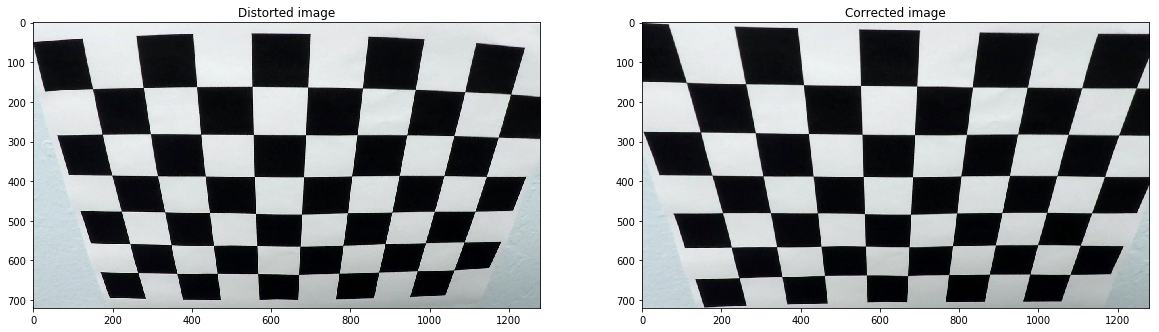

In [5]:
img = cv2.imread('camera_cal/calibration2.jpg')
corr_img = cal_image(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Distorted image')
ax1.imshow(img, cmap = "gray")

ax2.set_title('Corrected image')
ax2.imshow(corr_img, cmap='gray')

In [6]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Calculate directional gradient
    if orient == "x":
        sobel_edge = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel_edge = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Apply threshold
    abs_sobel_edge = np.absolute(sobel_edge)
    scaled_sobel_edge = np.uint8((255 * abs_sobel_edge)/(np.max(abs_sobel_edge)))
    grad_binary = np.zeros_like(scaled_sobel_edge)
    grad_binary[(scaled_sobel_edge >= abs_thresh[0]) & (scaled_sobel_edge <= abs_thresh[1])] = 1
    
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh = (0, 255)):
    # Calculate gradient magnitude
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    # Apply threshold
    scaled_sobel_edge = np.uint8((255 * abs_sobel)/(np.max(abs_sobel)))
    mag_binary = np.zeros_like(scaled_sobel_edge)
    mag_binary[(scaled_sobel_edge >= mag_thresh[0]) & (scaled_sobel_edge <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(20, 90)):
    # Calculate gradient direction
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)  
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    angle = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Apply threshold
    dir_binary = np.zeros_like(angle)
    dir_binary[(angle >= (dir_thresh[0] * (np.pi/180))) & (angle <= (dir_thresh[1] * (np.pi/180)))] = 1    
    return dir_binary

def sat_threshold(img, s_thresh = (170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return sat_binary

def pipeline(image, ksize, abs_threshx = (0, 255), abs_threshy = (0, 255),  mag_thresh = (0, 255), dir_thresh = (20, 90), s_thresh = (0, 255)):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_threshold(gray, 'x', ksize, abs_threshx)
    grady = abs_sobel_threshold(gray, 'y', ksize, abs_threshy)
    mag_binary = mag_threshold(gray, ksize, mag_thresh)
    dir_binary = dir_threshold(gray, ksize, dir_thresh)
    sat_binary = sat_threshold(image, s_thresh)
    assert(gradx.shape == grady.shape == mag_binary.shape == dir_binary.shape == sat_binary.shape)
   
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sat_binary ==1)] = 1
    
    return np.array(combined * 255, dtype = np.uint8)

In [7]:
def preProcess(image):
    '''Apply thresholding, correct distortion, apply perspective transform'''
    abs_threshx = (201, 255)
    abs_threshy = (161, 234)
    mag_thresh = (169, 255)
    dir_thresh = (65, 90)
    s_thresh =  (140, 255)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    image = cal_image(image, mtx, dist)

    result = pipeline(image, ksize, abs_threshx, abs_threshy, mag_thresh, dir_thresh, s_thresh)

    src = np.array([[(200, 720), 
                    (590, 450),
                    (690,450),
                    (1120, 720)
                    ]], np.float32)

    dest = np.array([[(310, 720), 
                    (310, 0),
                    (900,0),
                    (900, 720)
                     ]], np.float32)
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(result, 
                                M,
                                (image.shape[1], image.shape[0]),
                                flags = cv2.INTER_LINEAR)

    return warped

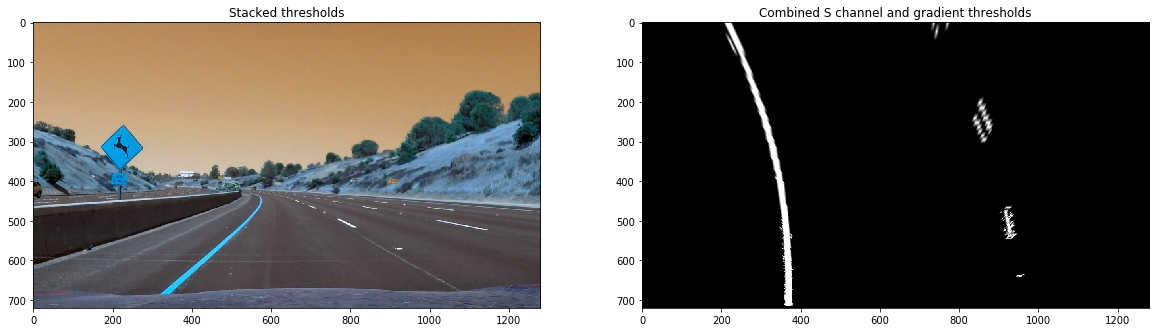

In [8]:
image = cv2.imread("test_images/test2.jpg")
warped = preProcess(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(image, cmap = "gray")

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(warped, cmap='gray')

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # print(nonzerox.shape)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds) 
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    binary_warped = np.copy(binary_warped)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img[np.array(ploty, dtype = np.int64), np.array(left_fitx, dtype = np.int64)] = [0, 255, 0]
    out_img[np.array(ploty, dtype = np.int64), np.array(right_fitx, dtype = np.int64)] = [0, 255, 0]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img

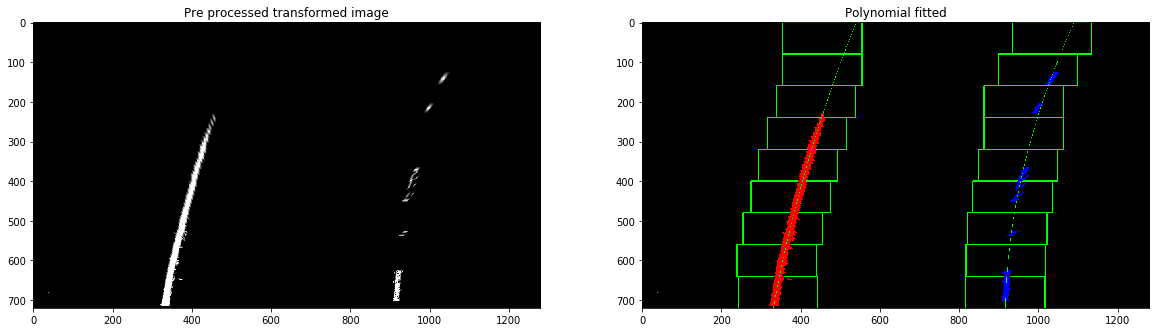

In [10]:
image = cv2.imread("test_images/test3.jpg")
warped = preProcess(image)
result = fit_polynomial(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Pre processed transformed image')
ax1.imshow(warped, cmap = "gray")

ax2.set_title('Polynomial fitted')
ax2.imshow(result, cmap='gray')

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output = 'project_video-out.mp4'

clip2 = VideoFileClip('project_video.mp4').subclip(0,30)
# clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))